In [41]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import MNIST
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
import torch.nn as nn
import os
from IPython.display import Image
from torchvision.utils import save_image

In [42]:
mnist=MNIST(root='data',train=True,download=False,transform=Compose([ToTensor(),Normalize(mean=(0.5,),std=(0.5,))]))

In [43]:
img,label=mnist[0]
print('Label: ',label)
print(img[:,10:15,10:15])
torch.min(img),torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [44]:
def denorm(x):
    out=(x+1)/2
    return out.clamp(0,1)

Label:  5


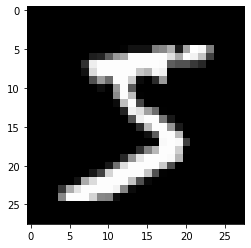

In [45]:
img_norm=denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print('Label: ',label)

In [46]:
batch_size=100
data_loader=DataLoader(mnist,batch_size,shuffle=True)

First Batch
torch.Size([100, 1, 28, 28])
tensor([1, 4, 5, 2, 7, 9, 6, 1, 6, 0, 9, 9, 0, 8, 6, 1, 7, 4, 4, 2, 5, 7, 1, 7,
        5, 3, 3, 1, 0, 1, 4, 7, 5, 2, 3, 1, 3, 8, 8, 0, 0, 2, 9, 5, 3, 3, 2, 6,
        7, 9, 5, 0, 1, 7, 0, 8, 5, 7, 5, 9, 0, 1, 4, 9, 3, 9, 8, 0, 0, 1, 4, 8,
        0, 2, 7, 9, 1, 4, 6, 9, 1, 2, 7, 4, 7, 7, 8, 7, 0, 1, 0, 7, 1, 3, 2, 9,
        7, 2, 9, 3])


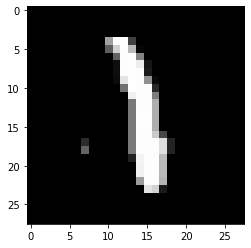

In [47]:
for img_batch, label_batch in data_loader:
    print('First Batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0],cmap='gray')
    print(label_batch)
    break

In [48]:
device=torch.device('cuda'if torch.cuda.is_available() else 'gpu')
device

device(type='cuda')

In [49]:
image_size=784
hidden_size=256

In [50]:
D=nn.Sequential(nn.Linear(image_size,hidden_size),nn.LeakyReLU(0.2),nn.Linear(hidden_size,hidden_size),nn.LeakyReLU(0.2),nn.Linear(hidden_size,1),nn.Sigmoid())

In [51]:
D.to(device);

In [52]:
latent_size=64

In [53]:
G=nn.Sequential(nn.Linear(latent_size,hidden_size),nn.ReLU(),nn.Linear(hidden_size,hidden_size),nn.ReLU(),nn.Linear(hidden_size,image_size),nn.Tanh())

In [54]:
y=G(torch.randn(2,latent_size))
gen_imgs=denorm(y.reshape((-1,28,28)).detach())

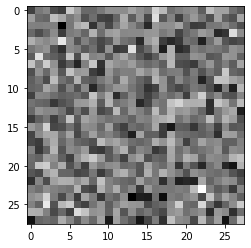

In [55]:
plt.imshow(gen_imgs[0],cmap='gray')

In [56]:
G.to(device);

In [57]:
criterion=nn.BCELoss()
d_optimizer=torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer=torch.optim.Adam(G.parameters(),lr=0.0002)

In [58]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels=torch.ones(batch_size,1).to(device)
    fake_labels=torch.zeros(batch_size,1).to(device)

    outputs=D(images)
    d_loss_real=criterion(outputs,real_labels)
    real_score=outputs
    z=torch.randn(batch_size,latent_size).to(device)
    fake_images=G(z)
    outputs=D(fake_images)
    d_loss_fake=criterion(outputs,fake_labels)
    fake_score=outputs
    d_loss=d_loss_real+d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss,real_score,fake_score




In [59]:
g_optimizer=torch.optim.Adam(G.parameters(),lr=0.0002)

In [60]:
z=torch.randn(batch_size,latent_size).to(device)
fake_images=G(z)
D(fake_images)

tensor([[0.5008],
        [0.5004],
        [0.4989],
        [0.4980],
        [0.5026],
        [0.5020],
        [0.5009],
        [0.4984],
        [0.4996],
        [0.4980],
        [0.5019],
        [0.5019],
        [0.4989],
        [0.4981],
        [0.5008],
        [0.4987],
        [0.4972],
        [0.5005],
        [0.4988],
        [0.4973],
        [0.5050],
        [0.5006],
        [0.4992],
        [0.4980],
        [0.5014],
        [0.5000],
        [0.4988],
        [0.5012],
        [0.5025],
        [0.4995],
        [0.5003],
        [0.4998],
        [0.5040],
        [0.5017],
        [0.4992],
        [0.4996],
        [0.4996],
        [0.5005],
        [0.4991],
        [0.5001],
        [0.5002],
        [0.4998],
        [0.4990],
        [0.4991],
        [0.4998],
        [0.5001],
        [0.5001],
        [0.4975],
        [0.5003],
        [0.5007],
        [0.4994],
        [0.4998],
        [0.4989],
        [0.4966],
        [0.5006],
        [0

In [66]:
def train_generator():
    z=torch.randn(batch_size,latent_size).to(device)
    fake_images=G(z)
    labels=torch.ones(batch_size,1).to(device)
    g_loss=criterion(D(fake_images),labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss,fake_images

In [67]:
sample_dir='sample'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

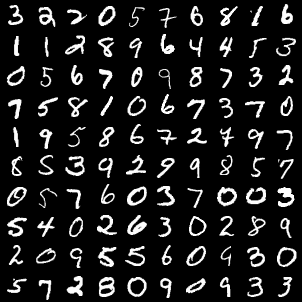

In [68]:
for images,_ in data_loader:
    images=images.reshape(images.size(0),1,28,28)
    save_image(denorm(images),os.path.join(sample_dir,'real_images.png'),nrow=10)
    break
Image(os.path.join(sample_dir,'real_images.png'))

Saving  fake_images-0000.png


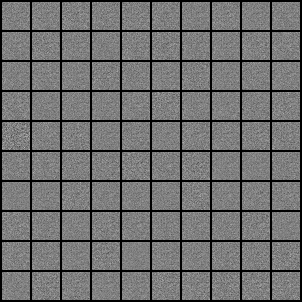

In [69]:
sample_vectors=torch.randn(batch_size,latent_size).to(device)

def save_fake_images(index):
    fake_images=G(sample_vectors)
    fake_images=fake_images.reshape(fake_images.size(0),1,28,28)
    fake_fname='fake_images-{:0=4d}.png'.format(index)
    print('Saving ',fake_fname)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=10)

save_fake_images(0)
Image(os.path.join(sample_dir,'fake_images-0000.png'))

In [75]:
%%time

num_epochs = 25
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/25], Step [200/600], d_loss: 0.1973, g_loss: 5.4736, D(x): 0.95, D(G(z)): 0.05
Epoch [0/25], Step [400/600], d_loss: 0.2210, g_loss: 3.5862, D(x): 0.94, D(G(z)): 0.06
Epoch [0/25], Step [600/600], d_loss: 0.3797, g_loss: 3.3468, D(x): 0.87, D(G(z)): 0.05
Saving  fake_images-0001.png
Epoch [1/25], Step [200/600], d_loss: 0.2729, g_loss: 3.8777, D(x): 0.91, D(G(z)): 0.06
Epoch [1/25], Step [400/600], d_loss: 0.4800, g_loss: 5.2536, D(x): 0.96, D(G(z)): 0.23
Epoch [1/25], Step [600/600], d_loss: 0.5809, g_loss: 4.0818, D(x): 0.94, D(G(z)): 0.23
Saving  fake_images-0002.png
Epoch [2/25], Step [200/600], d_loss: 0.2016, g_loss: 5.5232, D(x): 0.94, D(G(z)): 0.08
Epoch [2/25], Step [400/600], d_loss: 0.3408, g_loss: 4.1501, D(x): 0.87, D(G(z)): 0.06
Epoch [2/25], Step [600/600], d_loss: 0.3796, g_loss: 3.6442, D(x): 0.88, D(G(z)): 0.05
Saving  fake_images-0003.png
Epoch [3/25], Step [200/600], d_loss: 0.5738, g_loss: 2.9904, D(x): 0.85, D(G(z)): 0.10
Epoch [3/25], Step [400/600], d_l

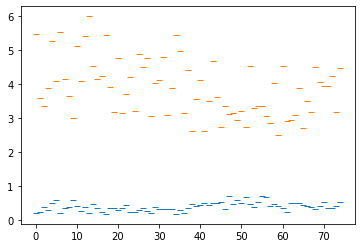

In [77]:
plt.plot(d_losses,'_')
plt.plot(g_losses,'_')